In [1]:
from data import train_df, test_df
import numpy as np
import pandas as pd

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null int64
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
Child          891 non-null int64
dtypes: float64(2), int64(7), object(4)
memory usage: 90.6+ KB


In [ ]:
train_df.describe()

*Remover entradas que possuem NaN reduz bastante o tamanho do dataset*

In [ ]:
train_df.dropna().describe()

## Análise inicial

In [ ]:
# pra ver quantas pessoas sobreviveram
train_df["Survived"].value_counts()

In [ ]:
# pra ver os percentuais de quem sobreviveu
train_df["Survived"].value_counts(normalize = True)

In [ ]:
# quantos homens sobreviveram
train_df["Survived"][train_df["Sex"] == 'male'].value_counts(normalize=True)

In [ ]:
# quantas mulheres sobreviveram
train_df["Survived"][train_df["Sex"] == 'female'].value_counts(normalize=True)

Proporcionalmente, um número maior de mulheres sobreviveram. Seria por causa da política de "mulheres e crianças primeiro"?

In [ ]:
# Existe o campo "Child"?
train_df.info()

In [2]:
# Completando os valores em branco para a mediana da feature "Age"
train_df['Age'] = train_df["Age"].fillna(train_df["Age"].median())
train_df["Child"] = 0
children = train_df["Age"] < 18
train_df.loc[children, "Child"] = 1
train_df["Survived"][train_df["Child"] == 0].value_counts(normalize=True)

0    0.638817
1    0.361183
Name: Survived, dtype: float64

In [3]:
# A feature 'Sex' precisa ser mapeada para inteiros
train_df['Sex'] = train_df['Sex'].map({'male': 0, 'female': 1})

In [6]:
# Vamos usar então as features 'Sex' e 'Child' para uma classificacao inicial
from sklearn import tree

# Separando o resultado e as features usadas
target = train_df['Survived'].values
initial_features = train_df[['Sex', 'Child']].values

# Da classifier
my_tree_one = tree.DecisionTreeClassifier().fit(initial_features, target)

# Look at the importance of the included features and print the score
print(my_tree_one.feature_importances_)
print(my_tree_one.score(initial_features, target))

[ 0.04533685  0.95466315]
0.786756453423


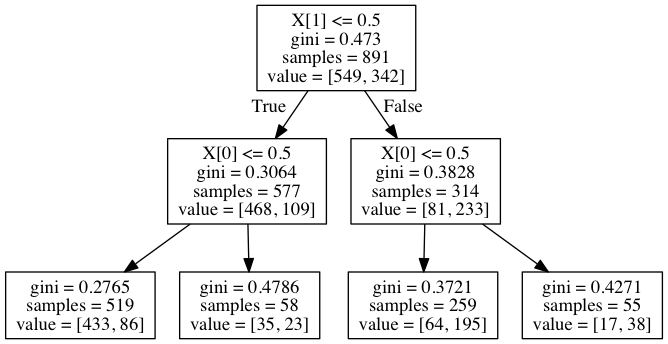

In [7]:
import pydotplus as pydot
from sklearn.externals.six import StringIO
from IPython.display import Image 
dotfile = StringIO()
tree.export_graphviz(my_tree_one, out_file=dotfile)
graph = pydot.graph_from_dot_data(dotfile.getvalue())
Image(graph.create_png())

A árvore de decisão funciona aplicando as decisões de cada nível ao exemplo passado como entrada. Ao se chegar a uma folha, a árvore checa o que aconteceu com a maioria dos exemplos que possuem aquelas características: se a maioria tiver sobrevivido, a árvore decide que o novo exemplo também deve ter sobrevivido. TODO: observações sobre o efeito de permutação de features na árvore resultante.

In [38]:
# Por exemplo, existem 55 crianças do sexo feminino no conjunto de treinamento. A maioria delas sobreviveram,
# o que pode ser visto na filtragem abaixo...
temp = train_df[train_df['Child'] == 1]
female_children = temp[temp['Sex'] == 1]
female_children.groupby('Survived').describe()

Age  Child        Fare      Parch  PassengerId  \
Survived                                                               
0        count  17.000000   17.0   17.000000  17.000000    17.000000   
         mean    8.441176    1.0   31.911765   1.411765   349.176471   
         std     5.061751    0.0   32.402672   0.795206   278.293064   
         min     2.000000    1.0    7.854200   0.000000    15.000000   
         25%     3.000000    1.0   15.245800   1.000000   115.000000   
         50%     9.000000    1.0   27.900000   2.000000   298.000000   
         75%    11.000000    1.0   31.275000   2.000000   543.000000   
         max    17.000000    1.0  151.550000   2.000000   853.000000   
1        count  38.000000   38.0   38.000000  38.000000    38.000000   
         mean    9.592105    1.0   33.172261   0.868421   416.342105   
         std     6.159595    0.0   39.725627   0.777072   279.844482   
         min     0.750000    1.0    7.225000   0.000000    10.000000   
         25%     4.000000    1.0   12.071875   0.000000   176.000000   
         50%    10.500000    1.0   19.379150   1.000000   441.500000   
         75%    15.750000    1.0   32.596875   1.000000   678.750000   
         max    17.000000    1.0  211.337500   2.000000   876.000000   

                   Pclass   Sex      SibSp  
Survived                                    
0        count  17.000000  17.0  17.000000  
         mean    2.882353   1.0   2.235294  
         std     0.485071   0.0   1.714986  
         min     1.000000   1.0   0.000000  
         25%     3.000000   1.0   1.000000  
         50%     3.000000   1.0   3.000000  
         75%     3.000000   1.0   4.000000  
         max     3.000000   1.0   5.000000  
1        count  38.000000  38.0  38.000000  
         mean    2.315789   1.0   0.736842  
         std     0.774780   0.0   1.031509  
         min     1.000000   1.0   0.000000  
         25%     2.000000   1.0   0.000000  
         50%     2.500000   1.0   0.000000  
         75%     3.000000   1.0   1.000000  
         max     3.000000   1.0   4.000000

In [48]:
# ...Logo, ao se passar para a árvore um exemplo consistindo de uma
# criança do sexo feminino, a árvore decidirá que ela deve ter sobrevivido.
new_female_child = pd.DataFrame(data=[[1, 1]], columns=['Gender', 'Child'])
prediction = my_tree_one.predict(new_female_child)
print(prediction)

[1]


In [51]:
SURVIVED = 1
DIED = 0

In [52]:
if (prediction[0] == SURVIVED):
    print('Survived :D')
else:
    print('Died :(')

Survived :D


In [35]:
test_features_df = test_df.ix[:, ['Sex', 'Age']]
test_features_df['Age'] = test_features_df["Age"].fillna(test_features_df["Age"].median())


test_features_df["Child"] = 0
children = test_features_df["Age"] < 18
test_features_df.loc[children, "Child"] = 1

test_features_df['Sex'] = test_features_df['Sex'].map({'male': 0, 'female': 1})

In [36]:
test_features = test_features_df[['Sex', 'Child']].values

test_targets = my_tree_one.predict(test_features)
test_df['Survived'] = test_targets

In [45]:
test_df.to_csv('./data/test_data_with_results.csv')

array([0, 1])

## Inclusão das features "Cabin" e "Fare"

In [15]:
cabin_fare_df = train_df.ix[:, ['Cabin', 'Fare']]
cabin_fare_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 2 columns):
Cabin    204 non-null object
Fare     891 non-null float64
dtypes: float64(1), object(1)
memory usage: 14.0+ KB


In [16]:
len(cabin_fare_df['Cabin'].unique())

148

A feature "Cabin" é categórica com um range relativamente grande(148 valores diferentes) e várias entradas vazias. Não é adequado codificar essa feature como uma sequência numérica pois isso implicaria uma ordenação dos valores, o que não condiz com a semântica dessa feature e poderia levar a resultados incoerentes. Essa feature será ignorada nesse momento e analisada por último como uma possível inclusão de informação para melhora do resultado final.